# Input

Time series $Z$ mixed with noise
$$Y = Z + E,$$
where $E$ is a whitenoise
$$
cov(E_i, E_j) =
\begin{cases}
\sigma_e^2,& i = j \\
0,&          i \neq j
\end{cases} 
$$

$Z$ depends on $X_i, i = 1..6$ time series.

# Task
- Find and remove anomalies in $Y$
- Create regression model $\mu$: $Z = \mu\left( X \right)$
- Find prediction for three more values of $Z$ by
  - extrapolation of $Z$
  - model $\mu\left( X \right)$ and prediction of $X$
- Estimate prediction errors
- Choose the best prediction

# Tools
- [Exponential smoothing](https://en.wikipedia.org/wiki/Exponential_smoothing)
- [Autoregressive model](https://en.wikipedia.org/wiki/Autoregressive_model)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (15.0, 15.0)

In [16]:
from numpy import loadtxt, arange, log
from pandas.stats.moments import ewma
from pandas import rolling_mean, rolling_std, Series
from statsmodels.tsa.stattools import adfuller

In [3]:
dataset = loadtxt('data.csv', skiprows=1, delimiter=',')
t = arange(dataset.shape[0])
y = dataset[:, 0]
xs = dataset[:, 1:].transpose()

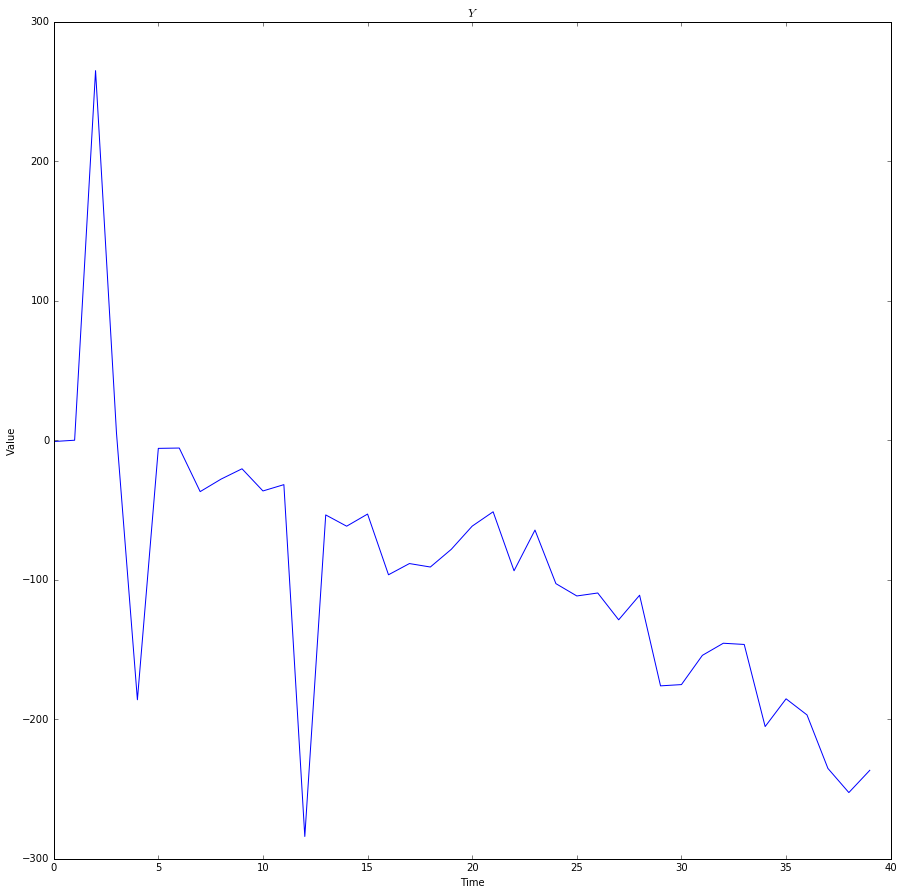

In [4]:
plt.plot(t, y)
plt.title('$Y$')
plt.ylabel('Value')
plt.xlabel('Time')
plt.show()

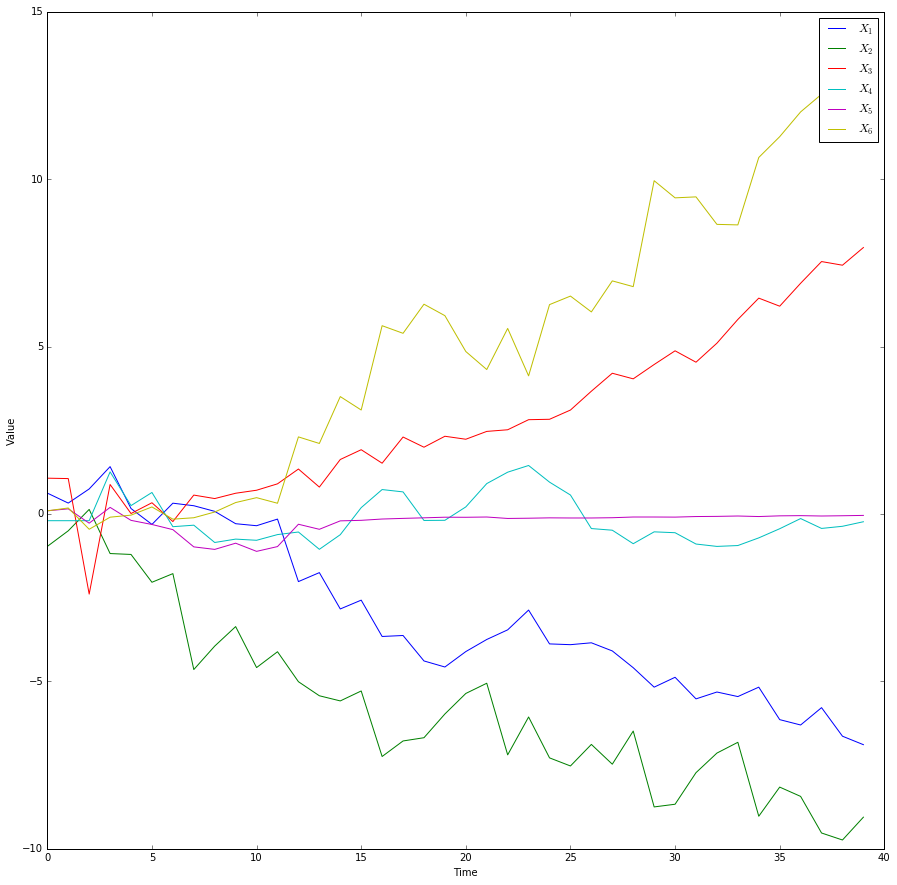

In [5]:
for i, x in enumerate(xs):
    plt.plot(t, x, label='$X_%d$'%(i+1))

plt.ylabel('Value')
plt.xlabel('Time')
plt.legend()
plt.show()